# Analyzing Roster Construction Through Positional Capital Allocation

### Particants: Ryan Burger

[ @BBBurger12](https://twitter.com/BBBurger12)

When I first started drafting on Underdog at the beginning of 2022, it was immediately clear how multi-faceted one single draft was. You had to focus on "staying within structure," while stacking your pass-catchers, and make sure you snag ADP values, too! All of this while trying to build in enough upside to take down a 451,200-field contest.

The aspect of drafting I've always been most fascinated by is positional draft capital allocation. When I first started, I certainly always tried to apply sound capital allocation, but it was more of an art than a science. I would look at the names and ADPs on my roster and go "hmmm yeah I think those WRs are good, let's chill there for a bit." I've heard many of the talking heads of the industry refer to viewing drafts through the lens of an "auction draft budget." In this case, we have a set amount of dollars (reflected by ADP) that we have to allocate to each position by the end of the draft.

Through this analysis, we will have developed a model that can assign "Capital" to a specific position, based on the pick number and the position that was selected. Following that, we can view each team's positional allocation of Capital, and develop a model that will predict advance rate based on that.

And to apply these models, we'll look at some specific examples of teams, as well as some barebones applications of these models that can be used for fun experimentation.

### Load in Packages + Data

Nothing particularly interesting here, just loading in the packages and the data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.utils import resample
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
import seaborn as sns
import numpy as np
import itertools
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import percentileofscore as pct

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load 2021

path = "/content/drive/MyDrive/Colab Notebooks/Best Ball Data Bowl/Data/best-ball-data-bowl/data/2021/regular_season"
csv_files = glob.glob(os.path.join(path, "*.csv"))

li = []

for filename in csv_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

bbm_2021 = pd.concat(li, axis=0, ignore_index=True)
bbm_2021["season"] = 2021
bbm_2021 = bbm_2021[["season", "pick_points", "player_name", "position_name", "overall_pick_number", "projection_adp", "playoff_team", "tournament_entry_id", "draft_id", "roster_points", "draft_time"]]

In [4]:
# Load 2022 - Mixed

path = "/content/drive/MyDrive/Colab Notebooks/Best Ball Data Bowl/Data/best-ball-data-bowl/data/2022/regular_season/mixed"
csv_files = glob.glob(os.path.join(path, "*.csv"))

li = []

for filename in csv_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

bbm_2022_mixed = pd.concat(li, axis=0, ignore_index=True)
bbm_2022_mixed["season"] = 2022

In [5]:
# Load 2022 - Fast

path = "/content/drive/MyDrive/Colab Notebooks/Best Ball Data Bowl/Data/best-ball-data-bowl/data/2022/regular_season/fast"
csv_files = glob.glob(os.path.join(path, "*.csv"))

li = []

for filename in csv_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

bbm_2022_fast = pd.concat(li, axis=0, ignore_index=True)
bbm_2022_fast["season"] = 2022

In [6]:
# Join 2022 Mixed + Fast

bbm_2022 = pd.concat([bbm_2022_mixed, bbm_2022_fast])[["season", "pick_points", "player_name", "position_name", "overall_pick_number", "projection_adp", "playoff_team", "tournament_entry_id", "draft_id", "draft_entry_id", "roster_points", "draft_time"]]

In [7]:
# Fix 2022 Playoff Teams

path = "/content/drive/MyDrive/Colab Notebooks/Best Ball Data Bowl/Data/best-ball-data-bowl/data/2022/post_season/quarterfinals"
csv_files = glob.glob(os.path.join(path, "*.csv"))

li = []

for filename in csv_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

bbm_2022_playoffs = pd.concat(li, axis=0, ignore_index=True)
bbm_2022_playoffs["season"] = 2022
playoff_team_ids = bbm_2022_playoffs["tournament_entry_id"]

bbm_2022["playoff_team"] = bbm_2022["tournament_entry_id"].isin(playoff_team_ids)*1

In [8]:
# Join 2021 + 2022

bbm = pd.concat([bbm_2021, bbm_2022]).replace({'position_name': {'FB': 'RB'}, 'projection_adp': {0.0:216.0}})
bbm["position_name"] = pd.Categorical(bbm["position_name"], ['QB', "RB", "WR", "TE"])

### Model Building: Player Capital

Now we get to build our model that will assign Capital to each pick. The target variable is "pick_points," which are the amount of points a player contributed to a specific best ball roster. The independent variables are "position_name," which simply is the player's position, and "overall_pick_number," which is the pick at which a player was selected.

A naive approach would possibly use linear regression to model the Capital. However, drafting experience informs us that the difference between picks 1 and 13 is *not* the same as the difference between 204 and 216. A more mature approach may try a logarithmic model, which would attempt to account for that inconsistency.

The preferred model for this analysis, however, was an XGBoost Regression model. This would be able to vary between any steep drop-offs that occur, as well as identify any flat tiers that exist. The model was model using a monotonicity constraint. This will force the model to decrease (or hold constant) Capital as the pick number increases. Rather, a later pick at a certain position will *never* be assigned more Capital than an earlier pick at that same position.

One additional modification was to upsample the 2021 dataset. Given that there are 155,375 teams from 2021 and 451,200 teams from 2022, that means that our training data would normally be heavily weighted toward the results from 2022. To combat this, we upsample the 2021 data, so there are an equal number of teams from 2021 and 2022. While an imperfect solution, it was important to make this change. Otherwise, the Jonathan Taylor selections that went 1.01 in 2022 would be considered ~3 times more than the CMCs that went 1.01 in 2021.

In [9]:
# split into train and test

train, test = train_test_split(bbm[["season", "pick_points", "position_name", "overall_pick_number"]], test_size = 0.3)

In [10]:
# split train into 2021 and 2022

train_2021 = train[train.season == 2021]
train_2022 = train[train.season == 2022]

In [11]:
# upsample 2021 observations

train_2021_upsample = resample(train_2021, n_samples = len(train_2022), replace = True)

In [12]:
# join train data back together with upsampled 2021 data

train_upsample = pd.concat([train_2021_upsample, train_2022])

In [13]:
# break train, test into x and y
# x: pick number, position
# y: pick points (points contributed to each roster)

x_train = train_upsample.drop(["pick_points", "season"], axis = 1)
x_train = pd.concat([x_train, pd.get_dummies(x_train.position_name)], axis = 1)[["overall_pick_number", "QB", "RB", "WR", "TE"]]
y_train = train_upsample.pick_points
x_test = test.drop(["pick_points", "season"], axis = 1)
x_test = pd.concat([x_test, pd.get_dummies(x_test.position_name)], axis = 1)[["overall_pick_number", "QB", "RB", "WR", "TE"]]
y_test = test.pick_points

In [14]:
# train xgboost regression
# force y (points) to decrease for increase in x (pick number)

reg = XGBRegressor(monotone_constraints = '(-1)')
reg.fit(x_train, y_train)
mean_squared_error(reg.predict(x_test), y_test)

2213.376484620883

### Vizualize Model Results

Now that we've built our model, we want to take a look at the value of each position at every pick.

In [15]:
# build data frame of every position + pick combination
# add predicted points based on pick number to data frame

picks = pd.DataFrame( \
  [list(range(1, 217))*4, \
  list(np.concatenate((np.repeat(1, 216), np.repeat(0, 216*3)), axis = 0)), \
  list(np.concatenate((np.repeat(0, 216), np.repeat(1, 216), np.repeat(0, 216*2)), axis = 0)), \
  list(np.concatenate((np.repeat(0, 216*2), np.repeat(1, 216), np.repeat(0, 216)), axis = 0)), \
  list(np.concatenate((np.repeat(0, 216*3),  np.repeat(1, 216)), axis = 0))]).transpose()

picks.columns = ["overall_pick_number", "QB", "RB", "WR", "TE"]

picks['proj_points'] = reg.predict(picks)
picks = picks.melt(id_vars = ['overall_pick_number', 'proj_points'], value_vars = ['QB', "RB", "WR", "TE"], var_name = 'position_name')
picks = picks[picks.value == 1]

In [16]:
udog_cols =  ["#9049b9", "#38997e", "#de7d1b", "#3a81ba"]

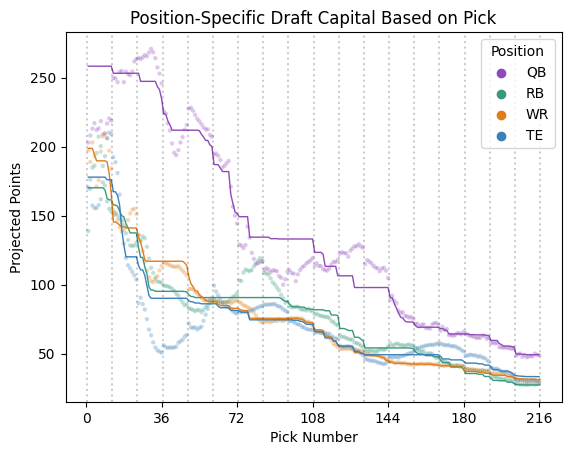

In [18]:
# plot proj points by pick number and position
# overlay with historical averages
picks_avg = bbm.groupby(['overall_pick_number', 'position_name'], as_index=False)['pick_points'].mean()

sns.lineplot(data = picks, x = 'overall_pick_number', y = 'proj_points', hue = 'position_name', linewidth = 1, palette = udog_cols, legend = False)
sns.scatterplot(data = picks_avg,  x = 'overall_pick_number', y = 'pick_points', hue = 'position_name', alpha = 0.3, s = 10, palette = udog_cols)
for x in np.arange(0.5, 217, 12):
  plt.axvline(x, linestyle = ':', c ='black', alpha = 0.2)
plt.grid(False)
plt.xlabel('Pick Number')
plt.xticks(ticks = [0, 36, 72, 108, 144, 180, 216])
plt.ylabel('Projected Points')
plt.legend(title = "Position")
plt.title("Position-Specific Draft Capital Based on Pick")
plt.show()

In the above chart, we can see the value of each pick for each position. The y-axis (Projected Points), is our proxy for Capital. More literally, it is how many points you can expect a player of that given position to contribute to you best ball roster. The lines are the predicted points at each pick. The dots that appear on the chart are the average of all picks that occurred at that pick number in 2021 and 2022.

So a QB, RB, WR, TE all taken at 1.01 can be expected to contribute roughly 260, 170, 180, and 200 points, respectively. And those positions at pick 84 would be roughly 140, 90, 80, and 80.

We can also see some clear flat tiers. WR, RB, TE all drop off quite a bit from pick 1 to pick 30, then flatten out until pick 50. WR and TE continue to drop a bit, while RB sees an incredibly flat tier basically from pick 30 all the way to around pick 95 (dead zone, anyone?). If we look closer at the green dots (actual points from RBs), we see that they perform better at picks 72-96. This fits intuition, as we saw running backs like Rhamondre Stevenson and Josh Jacobs smash at those picks. However, when examining those picks through the lens of Capital, we would not say that picks 72-96 are actually worth more than 36-72.

There are plenty more findings to be made here, that we simply don't have the words to go through in this notebook!

In [19]:
# calculate historic averages by pick, position, season

picks2 = bbm.groupby(['overall_pick_number', 'position_name', 'season'], as_index=False)['pick_points'].mean()
picks3 = pd.merge(picks2, picks, right_on = ['overall_pick_number', 'position_name'], left_on = ['overall_pick_number', 'position_name'])

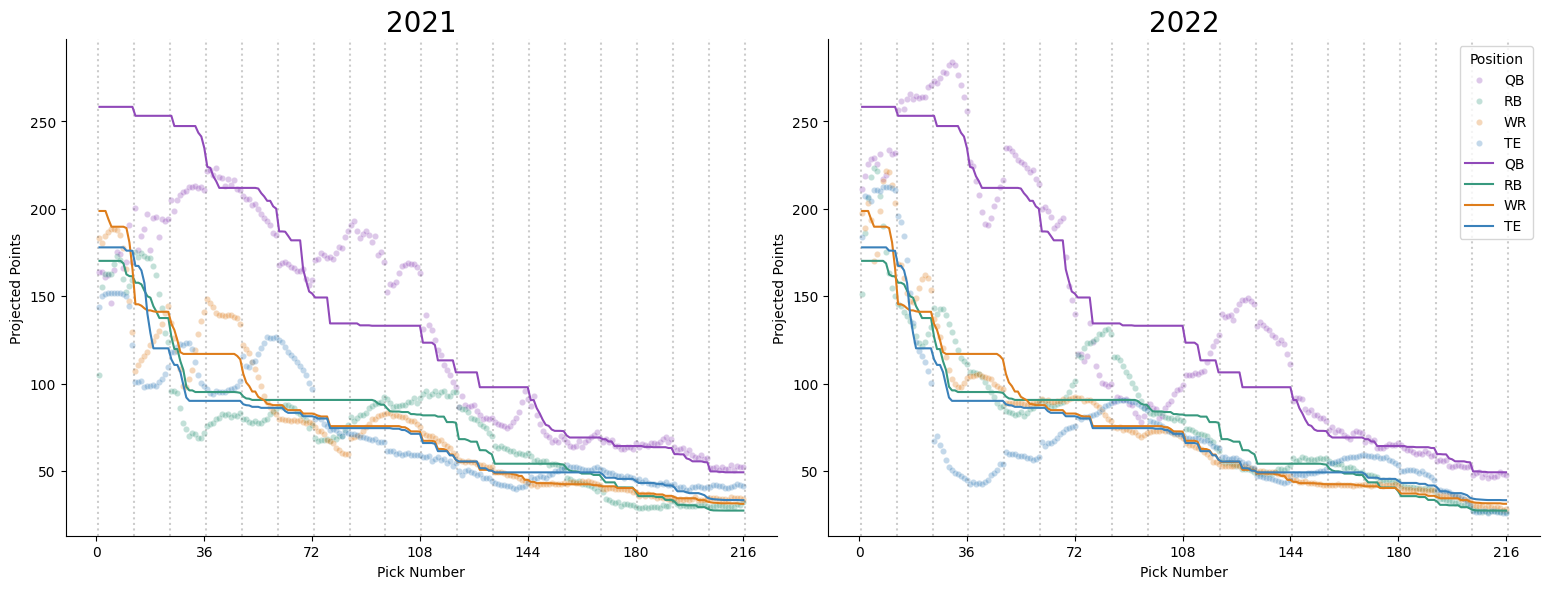

In [20]:
# plot 2021 and 2022

g = sns.FacetGrid(picks3, col = 'season', hue = 'position_name', height=6, aspect=1.3, palette = udog_cols)
g.set_titles("{col_name}", size = 20)
g.map(sns.scatterplot, 'overall_pick_number', 'pick_points', alpha = 0.3, s = 20)
for ax in g.axes.flat:
  ax.tick_params(labelleft=True)
  for x in np.arange(0.5, 217, 12):
    ax.axvline(x, linestyle = ':', c ='black', alpha = 0.2)
  ax.set_xticks(ticks = [0, 36, 72, 108, 144, 180, 216])
  ax.grid(False)
g.map(sns.lineplot, 'overall_pick_number', 'proj_points', linewidth = 1.5)
g.set(xlabel='Pick Number', ylabel='Projected Points')

plt.legend(title = "Position")
plt.show()

In [21]:
# delete unused data
del [bbm_2021, bbm_2022_mixed, bbm_2022_fast, bbm_2022_playoffs, bbm_2022]
del [train, test, train_2021, train_2021_upsample, train_2022, x_train, x_test, y_train, y_test]
del [picks, picks2, picks3, picks_avg]

Pictured above is the same graph as before, but the results (shown with the individual dots) are broken into 2021 and 2022.

### Model Building: Team Prediction

This next section takes the Capital from each pick and builds a model at the team level that can predict a specific team's probability of advancing. There are 8 predictors in this model, which are the total Capital at each of the 4 positions, as well as the number of players selected at each position. This model also applies monotonistic constraints: As the amount of points at a position increases, the probability of advancing *must* increase or remain constant. And on the other hand, as the number of players on a team increases, the probability of advancing *must* decrease or remain constant. To further expand on those constraints, if you have 2 TEs who are valued at 200 projected points (Capital), they should have a more positive contribution to your advance rate than 5 TEs that also combine for 200 projected points.

For the Capital of each player, the adp at the time of the selection was used. This decision was made over using the actual pick where the player was taken, because taking players at ADP values should lead to a higher advance rate. Taking a WR with ADP of 60 at pick 75 should be more positively impactful than a WR with ADP of 80 at 75.

In [22]:
# determine projected points of all historical bbm picks based on when when picked for each team
# apply same method based on player's current ADP
bbm_proj = bbm

bbm_proj["proj_pick_pts"] = reg.predict(pd.concat([bbm_proj, pd.get_dummies(bbm.position_name)], axis = 1)[["overall_pick_number", "QB", "RB", "WR", "TE"]])
bbm_proj["proj_adp_pts"] = reg.predict(pd.concat([bbm_proj, pd.get_dummies(bbm.position_name)], axis = 1)[["projection_adp", "QB", "RB", "WR", "TE"]].rename(columns={"projection_adp":"overall_pick_number"}))

In [23]:
# find each team's total projected points based on picks + ADP by position

bbm_proj1 = bbm_proj.groupby(["season", "roster_points", "tournament_entry_id", "position_name", "playoff_team"], observed=True, as_index = False)[["pick_points", "proj_pick_pts", "proj_adp_pts"]].agg(['sum', 'count'])
bbm_proj1 = bbm_proj1['proj_adp_pts'].reset_index().rename(columns={'sum': 'proj_adp_pts'})

In [24]:
# build data frame of each team's total projected points based on ADP, with each position as a column
bbm_proj2 = bbm_proj1[["season", "tournament_entry_id", "roster_points", "playoff_team", "position_name", "proj_adp_pts", "count"]].pivot_table(index = ("season", "tournament_entry_id", "playoff_team", "roster_points"), columns = "position_name", values = ["proj_adp_pts", "count"], observed = True).reset_index().rename(columns={'proj_adp_pts':'pts'})
bbm_proj2.columns = bbm_proj2.columns.map('_'.join).str.strip('_')

In [25]:
# create train and test data
# x: projected ADP points for each position
# y: boolean for whether team made playoffs/advanced

x = bbm_proj2.iloc[:, -8:]
y = bbm_proj2.playoff_team
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [26]:
clf = XGBClassifier(monotone_constraints = '(-1, -1, -1, -1, 1, 1, 1, 1)')
clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints='(-1, -1, -1, -1, 1, 1, 1, 1)',
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [27]:
roc_auc_score(clf.predict(x_test), y_test)

0.6739186040490861

In [28]:
bbm_proj2["playoff_odds"] = clf.predict_proba(bbm_proj2.iloc[:,-8:])[:,[1]]
bbm_proj2["odds_pctl"] = bbm_proj2.playoff_odds.rank(pct = True)
bbm_proj2[["pctl_QB", "pctl_RB", "pctl_TE", "pctl_WR"]] = bbm_proj2[["pts_QB", "pts_RB", "pts_TE", "pts_WR"]].rank(pct = True)

### Specific Team Examples

The function below will help visualize the players selected on each team, as well as their Capital allocation.

In [29]:
def view_team(id, df):
  df1 = df[df.tournament_entry_id == id].drop(["tournament_entry_id", "season"], axis = 1)
  df2 = pd.wide_to_long(df1, stubnames = ["count", "pts", "pctl"], sep = "_", suffix = "[A-Z]{2}", i=["playoff_odds", "odds_pctl", "playoff_team", "roster_points"], j='position').astype(float).round(2).reset_index()
  df2['position'] = pd.Categorical(df2['position'], ["QB", "RB", "WR", "TE"])

  plyf = "Made Playoffs" if df2.reset_index().playoff_team[0] == 1 else "Missed Playoffs"

  sns.set_style(style = "whitegrid")
  ax = sns.barplot(df2.reset_index(), x = "position", y = "pctl", palette = ["#9049b9", "#38997e", "#de7d1b", "#3a81ba"])
  ax.set_ylim(0, 1)
  ax.bar_label(ax.containers[0], labels=['%.1f' % p for p in df2.sort_values("position").pts], fontsize = 11)
  ax.bar_label(ax.containers[0], labels=['%.0f' % p for p in df2.sort_values("position")["count"]], label_type='center', color = 'white', fontsize = 14)
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
  ax.set(title = 'Playoff Odds: {:.1f}% ({:.1f}%ile)\nPoints Scored: {:.1f}\n{}'.format(df2.reset_index().playoff_odds.values[0]*100, df2.reset_index().odds_pctl.values[0]*100, df2.reset_index().roster_points.values[0], plyf),
         xlabel = "Position",
         ylabel = "Percentile")

  df = bbm_proj[bbm_proj.tournament_entry_id == id].sort_values("overall_pick_number")
  df = df[["position_name", "overall_pick_number", "projection_adp", "player_name", "proj_pick_pts", "proj_adp_pts", "pick_points"]]
  df['position_name'] = pd.Categorical(df['position_name'], ["QB", "RB", "WR", "TE"])
  df["adp_value_pts"] = df["proj_adp_pts"] - df["proj_pick_pts"]
  df3 = df.set_index(["position_name", "player_name", "projection_adp", "overall_pick_number"]).sort_index(level = [0,3]) \
  .rename_axis(index = {'position_name':'Position', 'projection_adp':  'ADP', 'player_name':'Player', 'overall_pick_number':'Pick #'})
  df3 = df3[["proj_adp_pts", "proj_pick_pts", "adp_value_pts", "pick_points"]]
  df3.columns = pd.MultiIndex.from_product([['Points From:'], ["ADP", "Pick #",  "ADP Value", "Team Contribution"]])

  rows = df.groupby("position_name").count().iloc[0:3,0]
  rows = [sum(rows[0:x:1]) for x in range(0, 4)][1:]

  display(df3.style \
    .format_index(precision = 1) \
    .format(precision = 1) \
    .set_table_styles(
        {
            ('Points From', 'Pick #'): [{'selector': 'th', 'props': ('border-left: 1px solid black')},
                                         {'selector': 'td', 'props': ('border-left: 1px solid black')}]
        },) \
    .set_table_styles(
     [
        {'selector' : '', 'props' : [('border', '1px solid black')]},
        #index header style
        {'selector': '.index_name', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('font-size', '16pt'), ('border-top', '1px solid black')]},
        {'selector': '.index_name:nth-child(2)', 'props': [('border-right',  '1px solid black')]},
        # table text style
        {'selector': 'td', 'props': [('text-align', 'center'), ('font-size', '12pt'), ('font-family', 'Tahoma')]},
        #
        {'selector': 'th:nth-child(5)', 'props': [('border-left',  '1px solid black')]},
        {'selector': 'th.blank.col1', 'props': [('border-left',  '1px solid black')]},
        {'selector': 'th.blank.col2', 'props': [('border-left',  '1px solid black')]},
        {'selector': 'th.blank.col3', 'props': [('border-left',  '1px solid black')]},
        #
        {'selector': 'tr:nth-child({})'.format(rows[0]), 'props': [('border-bottom',  '1px solid black')]},
        {'selector': 'tr:nth-child({})'.format(rows[1]), 'props': [('border-bottom',  '1px solid black')]},
        {'selector': 'tr:nth-child({})'.format(rows[2]), 'props': [('border-bottom',  '1px solid black')]},
        # points from style
        {'selector': 'th.col_heading.level0', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('font-size', '18pt')]},
        # lvl 1 column headers style
        {'selector': 'th.col_heading.level1','props': [('text-align', 'center'), ('vertical-align', 'center'), ('font-weight', 'bold'), ('font-size', '14pt'), ('border',  '1px solid black'), ('border-bottom',  'none')]},
        # header width
        {'selector': 'th.col_heading.level1.col0', 'props': [('column-width', '60px')]}, # ADP
        {'selector': 'th.col_heading.level1.col1', 'props': [('column-width', '60px')]}, # Pick #
        {'selector': 'th.col_heading.level1.col2', 'props': [('max-width', '50px')]}, # ADP Value
        {'selector': 'th.col_heading.level1.col3', 'props': [('max-width', '120px')]}, # Team Contribution
        {'selector': 'th.row_heading', 'props': [('text-align', 'center'), ('font-family', 'Tahoma')]},
        # position text style
        {'selector': 'th.row_heading.level0', 'props': [('text-align', 'center'), ('font-weight', 'bold'), ('font-size', '28pt')]},
        # player text style
        {'selector': 'th.row_heading.level1', 'props': [('text-align', 'left'), ('font-weight', 'bold'), ('font-size', '12pt'), ('border-right',  '1px solid black'), ('border-left',  '1px solid black')]},
        # adp style
        {'selector': 'th.row_heading.level2', 'props': [('text-align', 'center'),  ('font-weight', 'normal'), ('font-size', '12pt')]},
        # pick # style
        {'selector': 'th.row_heading.level3', 'props': [('text-align', 'center'),  ('font-weight', 'normal'), ('font-size', '12pt'), ('border-right',  '1px solid black')]},
     ], overwrite = True
    ) \
   # .apply(lambda x: ['background-color: #9049b9' if x.name[0] == "QB" else 'background-color: #38997e' if x.name[0] == "RB" else 'background-color: #de7d1b' if x.name[0] == "WR" else 'background-color: #3a81ba' if x.name[0] == "TE" else "" for r in x], axis = 1) \
    .apply_index(lambda x: ['background-color: #9049b9' if r == "QB" else 'background-color: #38997e' if r == "RB" else 'background-color: #de7d1b' if r == "WR" else 'background-color: #3a81ba' if r == "TE" else "" for r in x], axis = "rows", level = [0])
    #.apply_index(lambda x: ['border-bottom: 1px solid black' if x.reset_index().index == 3 else '' for r in x], axis = "rows", level= 2)
   # .apply(lambda x: ['border-bottom: 1px solid black' if x.name[0] == "QB" else '' for r in x], axis = "columns")
          )

#### KingKappital

It's only right that we take a look at KingKappital's championship-winning team. Not only does his name reference Capital, but it can provide a fantastic sanity test - if his team does not project well, that's not a good sign for the model.

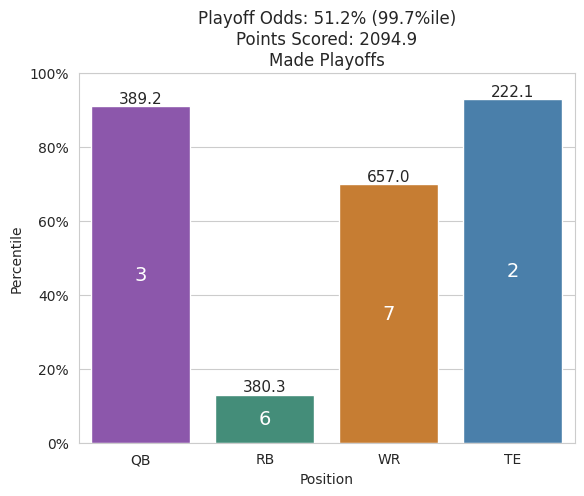

In [30]:
view_team("4eebdf9d-6857-4a35-864a-5c9376a02db9", bbm_proj2)

As we can see, the model loves KingKappital's team. His playoff odds are set at 44.8%, which was in the top 0.7% of teams. We can see that, according to his Capital allocation, he had elite (90%ile) QBs and TEs, good WRs(65-70%ile), and bad RBs(10-15%ile). This aligns with what we see on the roster. 2 QBs relatively early in Hurts and Burrow, and Kelce at TE should lead to high-end outcomes at those positions (and it sure did).

#### Best-projected team

Now we want to see what the very best team should look like. This team has elite TEs (thanks Kelce) and elite WRs, due to some massive ADP values. Taking Diggs at 12, with an ADP of 8.6 provided 21.8 points of value of Capital, and JuJu at 60 with an ADP of 45.9 lead to 29.4 points of value. The next 5 WRs were all taken behind ADP as well. This team also took Mahomes at 61, when his ADP was at 49.2, a big 23.9 point value. And even though the RBs were not much of a priority for this team, they still managed to salvage some good Capital, by taking 4 RBs 10+ picks after ADP.


Note: this team actually has the second-highest projected playoff odds, as the highest team was drafted on the first day, before ADPs were based on actual drafts.

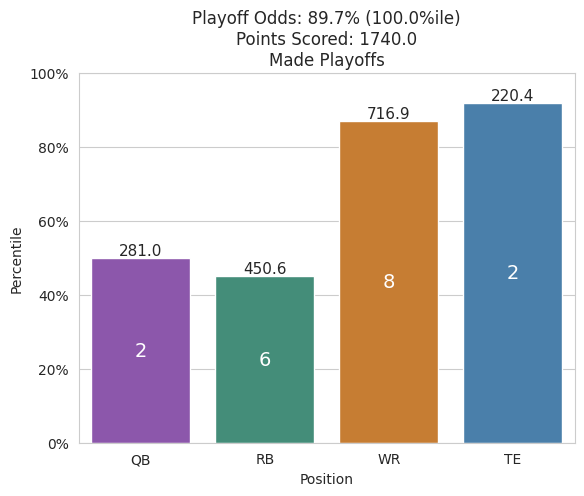

In [31]:
id = bbm_proj2.sort_values("playoff_odds").tail(2).tournament_entry_id.values[0]
view_team(id, bbm_proj2)

#### Worst-projected team

And now we look at a team with the worst odds. This team is completely unsurprising. They only took 1 late QB, and took 11 players who were basically undrafted. There's not a whole lot to learn from this team, but it is good to see that the model recognizes what we all would: this is an atrocious team.

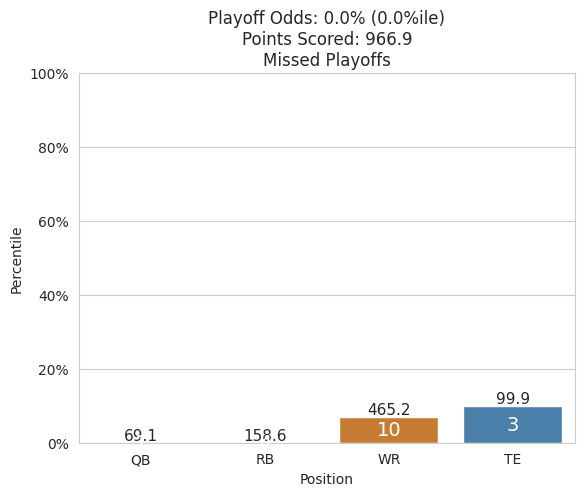

In [32]:
id = bbm_proj2.sort_values("playoff_odds").head(1).tournament_entry_id.values[0]
view_team(id, bbm_proj2)

### Conclusion

In building our initial Player Capital model, we can find tier breaks and figure out where to attack pockets of value. For example, picks 36-72 WRs outpace TEs and RBs, and picks 72-120+, RBs outpace the other skill positions.

The Player Capital model can be applied to team structure, and allows us to see how depedent our playoff odds/advance rate is based on when, and how much , we take of each position.

Below this section, you'll find an appendix that contains a few application and tool ideas. They are all functional, but are very limited. I encourage you to play around with them and try them out! And maybe they'll lead to additional inspiration. If anything stuck with you from this project, please DM me! I'd love to go deeper into this subject with anyone who is interested.

This project has been so fun to work on. I typically prefer to work in R, and I was really pleased to have the opportunity to enhance my python skills. I've been implementing these findings in my own drafts, and hope the see it all pay off in January!

Lastly, there are quite a few shortcomings that I want to address from this analysis:
*   **This analysis is descriptive, and not necessarily predictive**: This is purely based on the last 2 years' data. The market is constantly adapting every year, so a QB at pick 50 this year may not have the same value as a QB at 50 last year.
*   **Advance rate only tells part of the story**: When trying to take down a (at this point) 677,376 person tournament, you'll need to do more than just get teams to the playoffs.
*   **The rest of your draft room is ignored**: For the advance rate predictor and the corresponding tools, we don't know the quality of the rest of the draft room.
*   **There is no consideration for stacking or player archetypes**: The Pick Capital model only takes into account when a player was taken - it does not know if their production should be early or late in the season, if they carry a lot of contingent value, or if they are correlated with any other picks on the roster.

The following are additional ideas I would like to expand upon given more time:
*   **Build better models**: Simply put, there could be hyperparamter tuning/model exploration that could be performed that could help increase the quality of the models. Furthermore, adding additional features that cover topics like stacking, bye weeks, etc. could add more signal to the Team Prediction model.
*  **Use closing ADP instead of time-of-draft ADP**: Wth more time, this is a change I would have prioritized. I think there is value in both versions, but ultimately your team should be judged based off the most recent information.
*   **Building out real applications based on those in the appendix**: My python app development skills are minimal, but I would love to learn and build out real tools from this analysis.
*   **Develop Value-Based Drafting stratgies**: Using the Player Capital model, we could better figure out where the best values to attack each position lie in the draft.



### Appendix: Applications and Tool Ideas

#### Team *Finder*

This tool will take percentile inputs at each position and find the team that most closely matches those inputs.

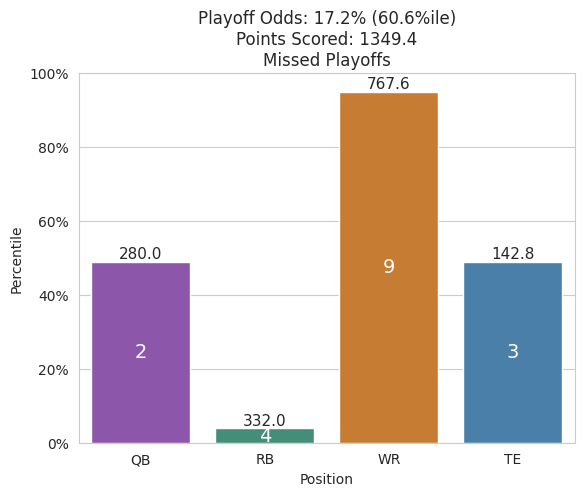

In [33]:
qb_pctl = .5
rb_pctl = .05
wr_pctl = .95
te_pctl = .5
bbm_proj2["dist"] = np.sqrt((bbm_proj2.pctl_QB - qb_pctl)**2+(bbm_proj2.pctl_RB - rb_pctl)**2+(bbm_proj2.pctl_WR - wr_pctl)**2+(bbm_proj2.pctl_TE - te_pctl)**2)
id = bbm_proj2[bbm_proj2.dist == bbm_proj2.dist.min()].tournament_entry_id.values[0]
view_team(id, bbm_proj2)

#### Exposure CSV Adv Rate Calculator

Input your exposure csv from Underdog, and it will spit out your average advance rate, as well as the total projected advancing teams. Pictured below are predictions based on my CSV from mid-July

In [34]:
# upload exposure csv to colab or set local file path
file_name = "underdog_exposures.csv"

def read_file(file_name):
  df = pd.read_csv(file_name)[["Pick Number", "First Name", "Last Name", "Position", "Tournament Title", "Draft"]]
  df.columns = [c.lower().replace(" ", "_") for c in df.columns]
  df["position"] = pd.Categorical(df["position"], ['QB', "RB", "WR", "TE"])
  df1 = pd.concat([df, pd.get_dummies(df.position)], axis = 1).drop("position", axis = 1)
  df["pred"] = reg.predict(df1.rename(columns={"pick_number":"overall_pick_number"})[["overall_pick_number", "QB", "RB", "WR", "TE"]])
  df2 = df.pivot_table(columns = "position", values = "pred", aggfunc = ('sum', 'count'), index = "draft")
  df2.columns = df2.columns.map('_'.join).str.strip('_')
  df2 = df2.rename(columns = {"sum_QB":"pts_QB", 'sum_RB':'pts_RB', 'sum_WR':'pts_WR', 'sum_TE':'pts_TE'})
  df2["playoff_odds"] = clf.predict_proba(df2.iloc[:,-8:])[:,1]
  df3 = df[["tournament_title", "draft"]].drop_duplicates().merge(df2["playoff_odds"].reset_index())
  return df3.groupby("tournament_title").agg(["count", "mean", "sum"]).sort_values("tournament_title")

read_file(file_name)

playoff_odds                     
                          count      mean        sum
tournament_title                                    
Best Ball Mania IV           50  0.202146  10.107282
SFB Satellite                 4  0.176565   0.706260
The Bulldog                   1  0.284701   0.284701
The Chihuahua                25  0.207912   5.197806
The Dalmatian                 1  0.239535   0.239535
The Dalmatian 2               2  0.112118   0.224237
The Fast Puppy               33  0.192722   6.359824
The Pomeranian               20  0.204705   4.094094
The Pomeranian 2             10  0.203172   2.031717
The Poodle                   14  0.176318   2.468451
The Poodle 2                 20  0.187533   3.750660
The Poodle 3                 15  0.213325   3.199879
The Puppy                    50  0.174327   8.716366
The Puppy 2                  90  0.183251  16.492590

#### Enter Custom Team Info

Manually input each draft pick and see each position's Capital percentile, and your playoff odds

In [35]:
def view_single_team(df):
  df["proj_points"] = reg.predict(pd.concat([df, pd.get_dummies(df.position)], axis = 1)[["adp", "QB", "RB", "WR", "TE"]].rename(columns = {"adp":"overall_pick_number"}))
  df1 = df.groupby("position", as_index = False)["proj_points"].agg(['sum', 'count']).reset_index()
  df1["position"] = pd.Categorical(df1["position"], ['QB', "RB", "WR", "TE"])
  df1["ind"] = "a"
  df1 = df1.pivot_table(index = "ind", columns = "position", values = ["sum", "count"]).reset_index().rename(columns={'sum':'pts'}).drop("ind", axis =1)
  df1.columns = df1.columns.map('_'.join).str.strip('_')
  df1["playoff_odds"] = clf.predict_proba(df1.iloc[:,-8:])[:,[1]]
  df1["pctl_QB"] = pct(bbm_proj2.pts_QB, df1.pts_QB)/100
  df1["pctl_RB"] = pct(bbm_proj2.pts_RB, df1.pts_RB)/100
  df1["pctl_WR"] = pct(bbm_proj2.pts_WR, df1.pts_WR)/100
  df1["pctl_TE"] = pct(bbm_proj2.pts_TE, df1.pts_TE)/100

  df2 = pd.wide_to_long(df1, stubnames = ["count", "pts", "pctl"], sep = "_", suffix = "[A-Z]{2}", i="playoff_odds", j='position').astype(float).round(2).reset_index()
  df2['position'] = pd.Categorical(df2['position'], ["QB", "RB", "WR", "TE"])
  sns.set_style(style = "whitegrid")
  ax = sns.barplot(df2.reset_index(), x = "position", y = "pctl", palette = ["#9049b9", "#38997e", "#de7d1b", "#3a81ba"])
  ax.set_ylim(0, 1)
  ax.bar_label(ax.containers[0], labels=['%.1f' % p for p in df2.sort_values("position").pts], fontsize = 11)
  ax.bar_label(ax.containers[0], labels=['%.0f' % p for p in df2.sort_values("position")["count"]], label_type='center', color = 'white', fontsize = 14)
  ax.set(title = 'Playoff Odds: {:.1f}%'.format(df2.reset_index().playoff_odds.values[0]*100),
         xlabel = "Position",
         ylabel = "Percentile")

##### Pete's 100th BBM draft (7/24)

Here's how Pete's 100th team is projected based on the ADPs at the time of the draft. Looks pretty good!!

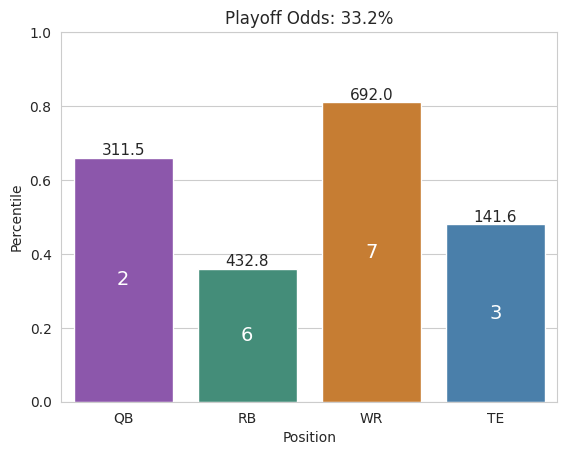

In [36]:
position = ["QB", "QB", "RB" ,"RB", "RB", "RB", "RB", "RB", "WR", "WR", "WR", "WR", "WR", "WR", "WR", "TE", "TE", "TE"]
adp = [27.9, 181.5, 38.9, 65.8, 106.6, 109.7, 137.3, 204.3, 7.9, 16.3, 45.7, 74, 98.2, 154.5, 158.2, 134.3, 151.7, 186.5]

team = pd.DataFrame(list(zip(position, adp)), columns = ["position",  "adp"])
view_single_team(team)

#### Read Team Image (beta)

Input a screenshot (generated by Underdog) of your team and see how it looks! The current output is based on an image of one of my own drafts.

Possible bugs:
*   Does not do well if a player doesn't have an assigned team
*   One team had Zay Jones and that kind of broke it??
*   Probably more that I haven't found!






In [37]:
!pip install easyocr
import easyocr

In [38]:
img_name = "IMG_4775.JPG"

reader = easyocr.Reader(['en'])
result = [r[1] for r in reader.readtext(img_name, min_size = 8)]

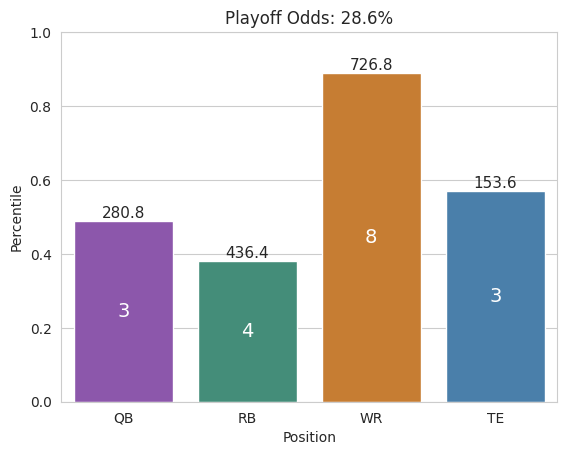

In [39]:
player = list(range(18))
adp = list(range(18))
pick = list(range(18))
position = list(range(18))
pos = "QB"
mod = 0
for i in range(18):
  i1 = 11 + 8*i + mod
  if result[i1] in ["QB", "WR", "RB", "TE"]:
    pos = result[i1]
    mod+=1
    i1+=1
  player[i] = result[i1]
  adp[i] = float(result[i1+2])
  pick[i] = int(result[i1+3])
  position[i] = pos
team = pd.DataFrame(list(zip(position, player, adp, pick)), columns = ["position", "player", "adp", "pick"])

view_single_team(team)